In [284]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [206]:
import torchvision
from torchvision import datasets

train_data = datasets.CIFAR10(
    root = 'CIFAR/',
    train = True,
    download = True,
    transform = torchvision.transforms.ToTensor()
)

test_data = datasets.CIFAR10(
    root = 'CIFAR/',
    train = False,
    download = True,
    transform = torchvision.transforms.ToTensor()
)


Text(0.5, 1.0, 'frog')

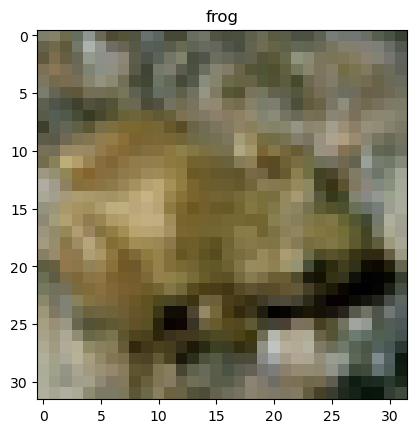

In [207]:
import matplotlib.pyplot as plt
import torch
random_image = torch.randint(0, len(train_data), size = [1]).item()
image, label = train_data[random_image]
class_names = train_data.classes
image = image.permute(1, 2, 0)
plt.imshow(image)
plt.title(class_names[label])

In [777]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle =False)
len(train_dataloader), len(test_dataloader)

(50000, 10000)

In [779]:
train_feature_batch, train_label_batch = next(iter(train_dataloader))
train_feature_batch.shape, train_label_batch.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1]))

(-0.5, 31.5, 31.5, -0.5)

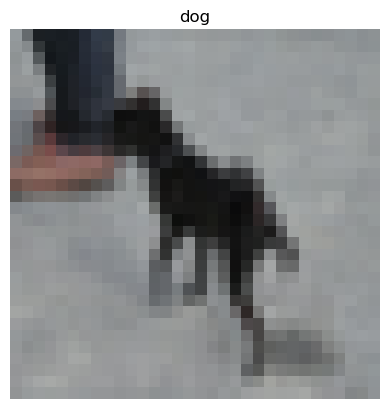

In [781]:
random_batch_image_idx = torch.randint(0, len(train_feature_batch), size = [1]).item()
image, label = train_feature_batch[random_batch_image_idx], train_label_batch[random_batch_image_idx]
image = image.permute(1, 2, 0)
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False)

In [783]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [891]:
from torch import nn
class CIFARMODEL(nn.Module):
    def __init__(self, input_features: int, output_features: int, hidden_features: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_features,
                      out_channels = hidden_features,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_features,
                      out_channels = hidden_features,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_features,
                      out_channels = hidden_features,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = hidden_features,
                      out_channels = hidden_features,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_features * 4 * 4,
                      out_features = hidden_features),
            nn.Dropout(0.4),
            nn.Linear(in_features = hidden_features,
                      out_features = output_features),

        )

    def forward(self, x):
        x = self.conv_block_1(x)
        #print(f"Output shape after passing Conv block 1: {x.shape}")
        x = self.conv_block_2(x)
        #print(f"Output shape after passing Conv block 2: {x.shape}")
        x = self.classifier(x)
        #print(f"Output shape after passing Classifier: {x.shape}")
        return x
                      
        

In [893]:
model = CIFARMODEL(input_features = 3,
                   hidden_features = 32,
                   output_features = len(class_names)).to(device)

# Loading CNN model

In [896]:
from pathlib import Path
PATH = Path("C:/Users/aniru/Pytorch 🔥🔥/models/CIFAR_CNN.pth")
model.load_state_dict(torch.load(PATH, weights_only=True))


<All keys matched successfully>

# Evaluating model

In [898]:
model.eval()
test_acc = 0
y_preds = []
true_preds = []
with torch.inference_mode():
    for X_test, y_test in (test_dataloader):
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_logits = model(X_test)
        y_pred = y_logits.argmax(1)
        test_acc +=accuracy_fn(y_true = y_test,
                               y_pred = y_pred)        
        y_preds.append(y_pred.cpu())
        true_preds.append(y_test.cpu())

    test_acc /= len(test_dataloader)
    print(f"Test accuracy: {test_acc}")

y_preds_tensor = torch.cat(y_preds)
true_preds_tensor = torch.cat(true_preds)

Test accuracy: 78.6


In [899]:
import torchmetrics
import mlxtend

C:\Users\aniru\AppData\Local\Temp\ipykernel_7952\1040929065.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_tensor = torch.tensor(y_preds_tensor)
C:\Users\aniru\AppData\Local\Temp\ipykernel_7952\1040929065.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true_tensor = torch.tensor(true_preds_tensor)


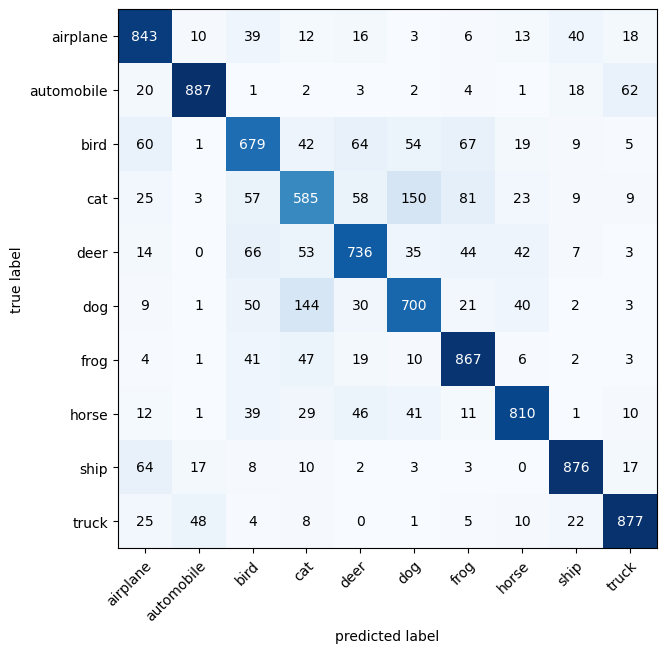

In [900]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


y_pred_tensor = torch.tensor(y_preds_tensor)
y_true_tensor = torch.tensor(true_preds_tensor)


confmat = ConfusionMatrix(num_classes = len(class_names), task="multiclass")


confmat.update(y_preds_tensor, y_true_tensor)
confmat_tensor = confmat.compute()

fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize = (10, 7)

)

# Making Predinctions

In [811]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample
            sample = torch.unsqueeze(sample, dim = 0).to(device)

        # Forward pass
            pred_logit = model(sample)

        # Get pred probability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

        # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack pred_probs to turn list into tensor
    return torch.stack(pred_probs)

In [813]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k = 9):
    test_samples.append(sample)
    test_labels.append(label)
    #View the firs sample shape
test_samples[0].shape

torch.Size([3, 32, 32])

Text(0.5, 1.0, 'cat')

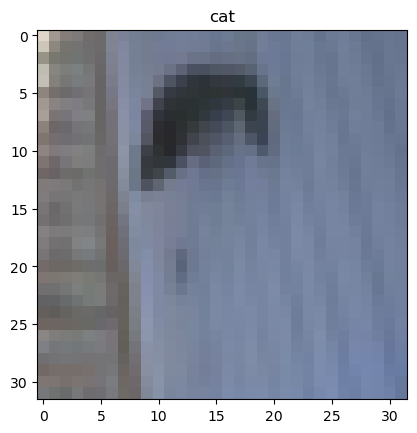

In [708]:
plt.imshow(test_samples[0].T.squeeze())
plt.title(class_names[test_labels[0]])

In [711]:
# Make predictions
pred_probs = make_predictions(model = model,
                              data = test_samples)

# View first two predictions
pred_probs[:2]

tensor([[7.0707e-02, 2.8757e-03, 3.8130e-01, 2.8413e-01, 6.3275e-02, 9.8867e-02,
         3.0895e-02, 3.8685e-02, 2.7192e-02, 2.0767e-03],
        [4.3470e-04, 3.1615e-07, 2.6570e-01, 1.9893e-01, 1.9465e-01, 3.8600e-02,
         2.9659e-01, 1.5061e-03, 3.5797e-03, 2.6351e-06]])

In [713]:
pred_classes = pred_probs.argmax(dim = 1)
pred_classes

tensor([2, 6, 0, 9, 0, 7, 8, 8, 1])

<function matplotlib.pyplot.show(close=None, block=None)>

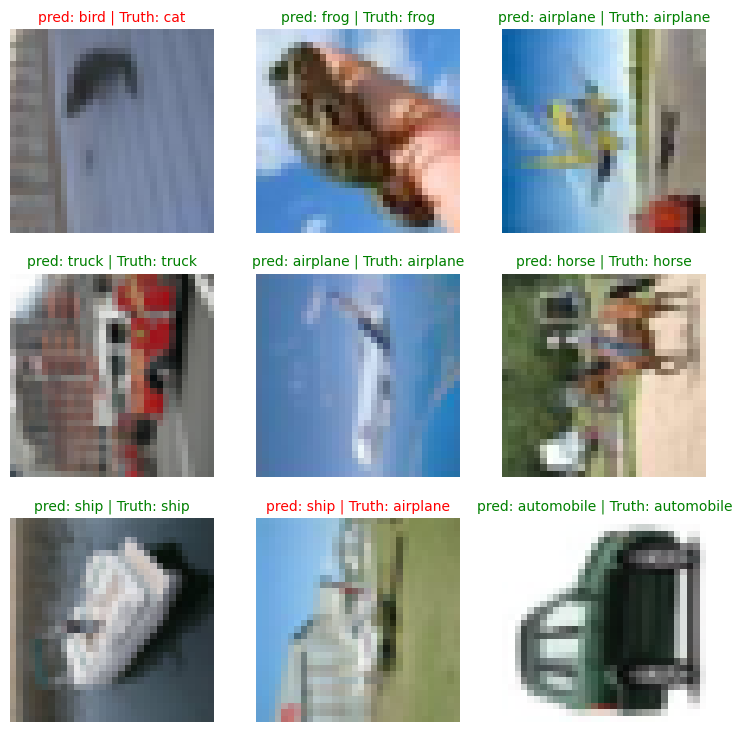

In [715]:
#plot predictions
plt.figure(figsize = (9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    #create subplot
    plt.subplot(nrows, ncols, i + 1)

    # plot the target image
    plt.imshow(sample.T.squeeze())

    # Find pred labels 
    pred_label = class_names[pred_classes[i]]

    # Get truth label
    truth_label = class_names[test_labels[i]]

    # Create title for the plot
    title_text = f"pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize = 10, c = "g")
    else:
        plt.title(title_text, fontsize = 10, c = "r")

    plt.axis(False)
               
plt.show

# Advereseral Attack
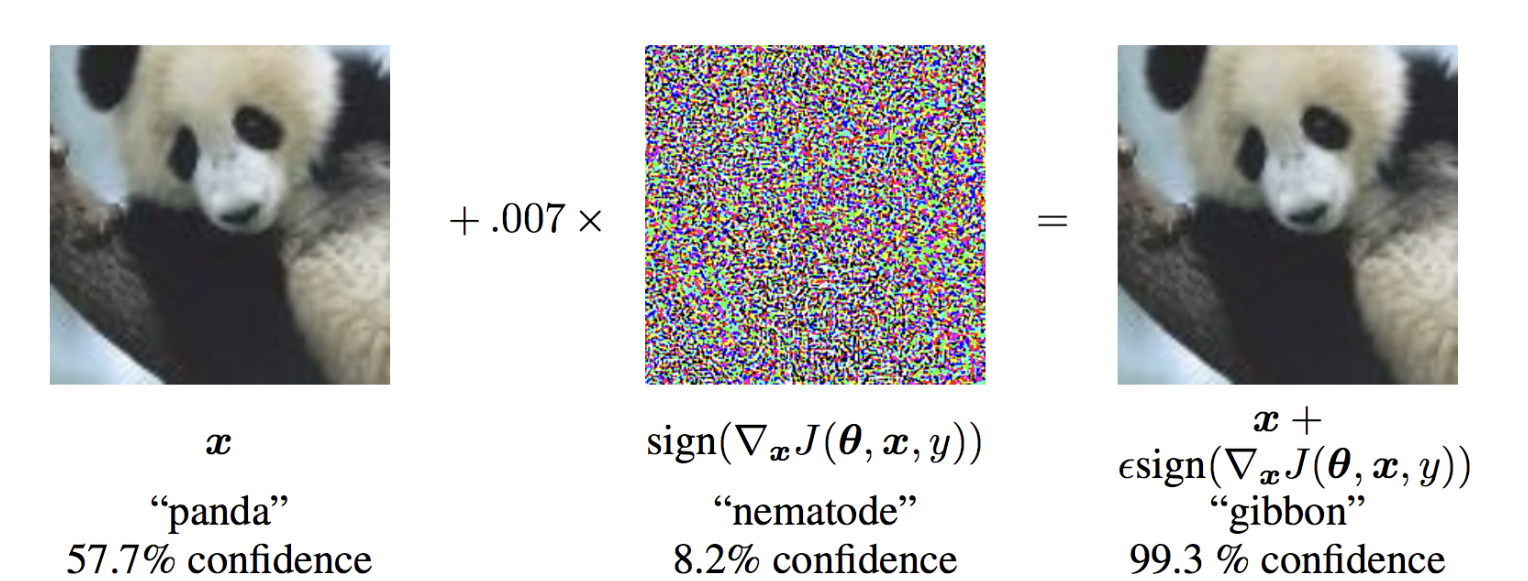

In [718]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0, 1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [720]:
import torch
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for batch, (data, target) in enumerate(test_loader):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        #print(f"init_pred: {init_pred.shape}")
        #print(f"target: {target.shape}")
        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

# Testing model on perturbed data

In [901]:
accuracies = []
examples = []
epsilons = [0, .001, 0.1]
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_dataloader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 7860 / 10000 = 0.786
Epsilon: 0.001	Test Accuracy = 4331 / 10000 = 0.4331
Epsilon: 0.1	Test Accuracy = 848 / 10000 = 0.0848


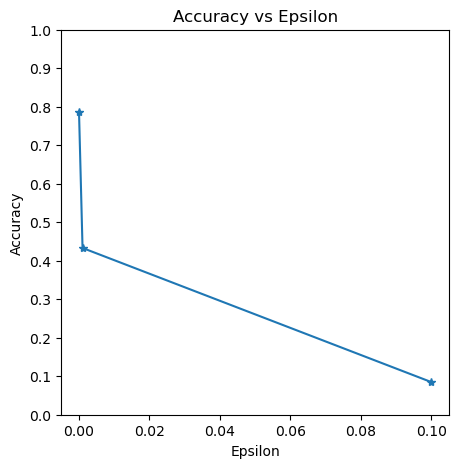

In [902]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.12, step=0.02))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

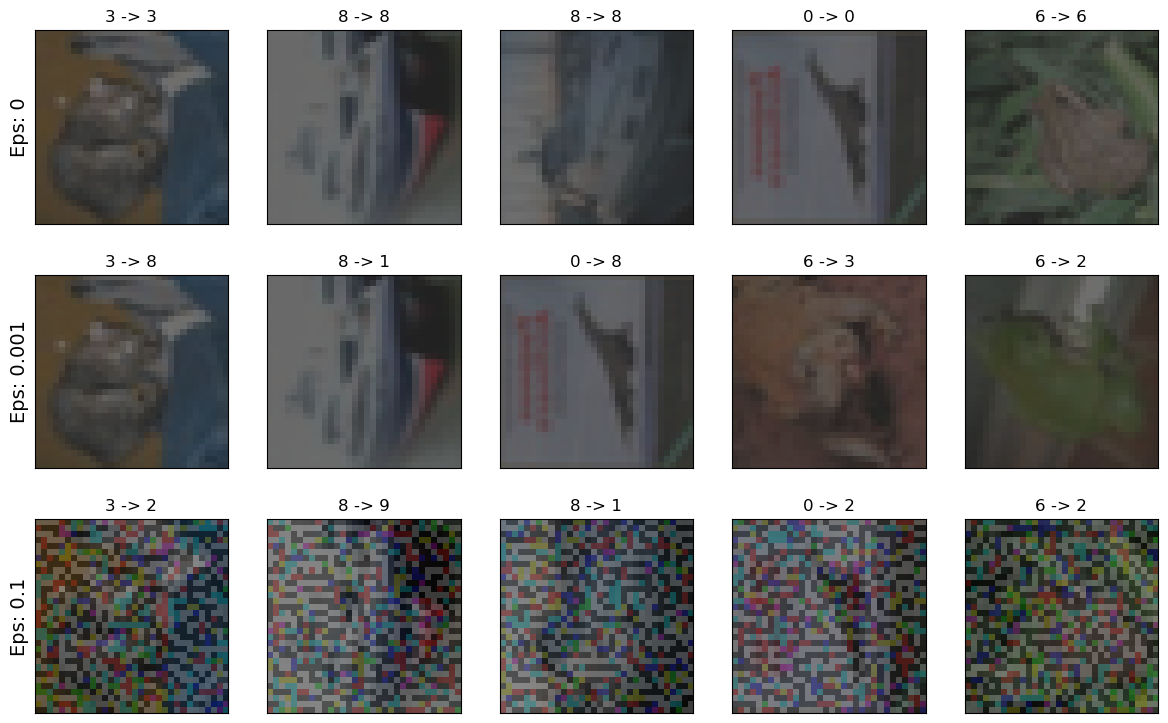

In [910]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(14.5,9))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex.T)
plt.show()

# Making the model robust

In [699]:
import torch
import torch.nn as nn
import torch.optim as optim

# Dummy model, loss, and data loader
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epsilon = 0.03  # Maximum perturbation (l_inf bound)
num_epochs = 5
def fgsm_attack(data, grad, epsilon):
    """FGSM inner maximization step: generate adversarial example"""
    return data + 0.001 * grad.sign()

# Training Loop with Min-Max Adversarial Training
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Enable gradients on inputs for attack
        images.requires_grad = True

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward to compute gradient w.r.t. inputs
        model.zero_grad()
        loss.backward()
        data_grad = images.grad.data

        # Generate adversarial example (maximizing inner loss)
        adv_images = fgsm_attack(images, data_grad, epsilon)
        adv_images = torch.clamp(adv_images, 0, 1)

        # Minimize outer loss: model on adversarial examples
        model.zero_grad()
        adv_outputs = model(adv_images.detach())
        adv_loss = criterion(adv_outputs, labels)

        adv_loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}], Adversarial Loss: {adv_loss.item():.4f}")


Epoch [1], Adversarial Loss: 0.6015
Epoch [2], Adversarial Loss: 0.3951
Epoch [3], Adversarial Loss: 0.0072
Epoch [4], Adversarial Loss: 0.1323
Epoch [5], Adversarial Loss: 0.0042


# Saving the model

In [746]:
from pathlib import Path
# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True,
                 exist_ok = True)
MODEL_NAME = "ROBUST_CIFAR_CNN.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model.state_dict(),
           f = MODEL_SAVE_PATH
          )

Saving model to: models\ROBUST_CIFAR_CNN.pth


In [826]:
PATH = Path("C:/Users/aniru/Pytorch 🔥🔥/models/ROBUST_CIFAR_CNN.pth")
model.load_state_dict(torch.load(PATH, weights_only=True))


<All keys matched successfully>

# Evaluating robust model

In [830]:
model.eval()
test_acc = 0
y_preds = []
true_preds = []
with torch.inference_mode():
    for X_test, y_test in (test_dataloader):
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_logits = model(X_test)
        y_pred = y_logits.argmax(1)
        test_acc +=accuracy_fn(y_true = y_test,
                               y_pred = y_pred)        
        y_preds.append(y_pred.cpu())
        true_preds.append(y_test.cpu())

    test_acc /= len(test_dataloader)
    print(f"Test accuracy: {test_acc}")

y_preds_tensor = torch.cat(y_preds)
true_preds_tensor = torch.cat(true_preds)

Test accuracy: 69.3


C:\Users\aniru\AppData\Local\Temp\ipykernel_7952\1040929065.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_tensor = torch.tensor(y_preds_tensor)
C:\Users\aniru\AppData\Local\Temp\ipykernel_7952\1040929065.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true_tensor = torch.tensor(true_preds_tensor)


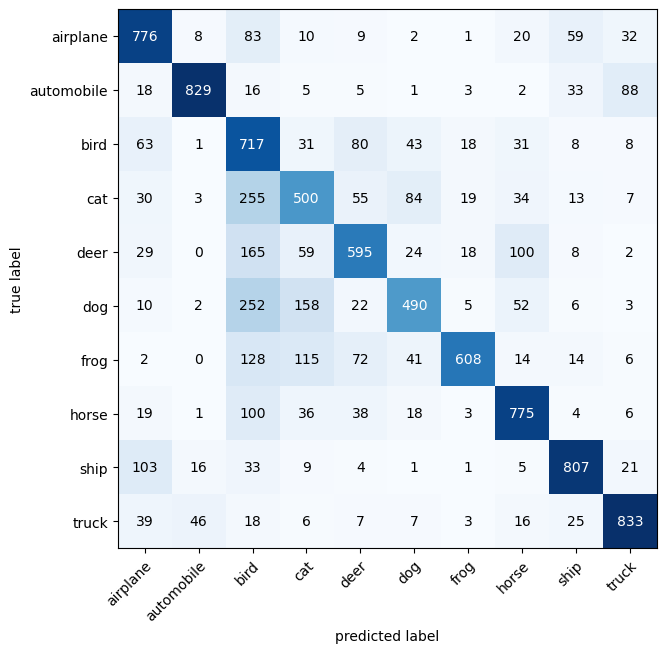

In [833]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


y_pred_tensor = torch.tensor(y_preds_tensor)
y_true_tensor = torch.tensor(true_preds_tensor)


confmat = ConfusionMatrix(num_classes = len(class_names), task="multiclass")


confmat.update(y_preds_tensor, y_true_tensor)
confmat_tensor = confmat.compute()

fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize = (10, 7)

)

# Making predictions

In [836]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample
            sample = torch.unsqueeze(sample, dim = 0).to(device)

        # Forward pass
            pred_logit = model(sample)

        # Get pred probability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

        # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack pred_probs to turn list into tensor
    return torch.stack(pred_probs)

In [838]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k = 9):
    test_samples.append(sample)
    test_labels.append(label)
    #View the firs sample shape
test_samples[0].shape

torch.Size([3, 32, 32])

Text(0.5, 1.0, 'horse')

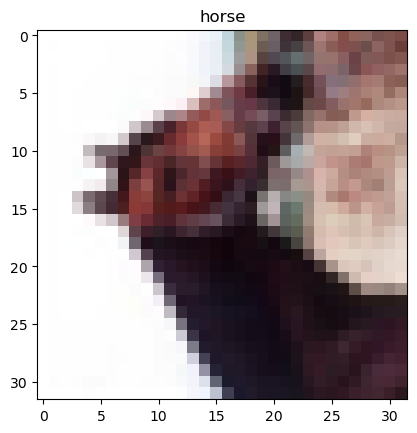

In [842]:
plt.imshow(test_samples[0].T.squeeze())
plt.title(class_names[test_labels[0]])

In [844]:
# Make predictions
pred_probs = make_predictions(model = model,
                              data = test_samples)

# View first two predictions
pred_probs[:2]

tensor([[1.2324e-02, 1.7289e-07, 1.1865e-01, 8.5698e-03, 3.5698e-03, 7.5257e-03,
         7.2998e-06, 8.4933e-01, 1.4223e-05, 6.1475e-06],
        [3.6288e-03, 1.6929e-04, 7.6203e-03, 3.7134e-03, 2.6748e-02, 1.0082e-02,
         2.6677e-04, 9.4608e-01, 2.9043e-04, 1.3985e-03]])

In [846]:
pred_classes = pred_probs.argmax(dim = 1)
pred_classes

tensor([7, 7, 2, 6, 8, 6, 8, 6, 1])

<function matplotlib.pyplot.show(close=None, block=None)>

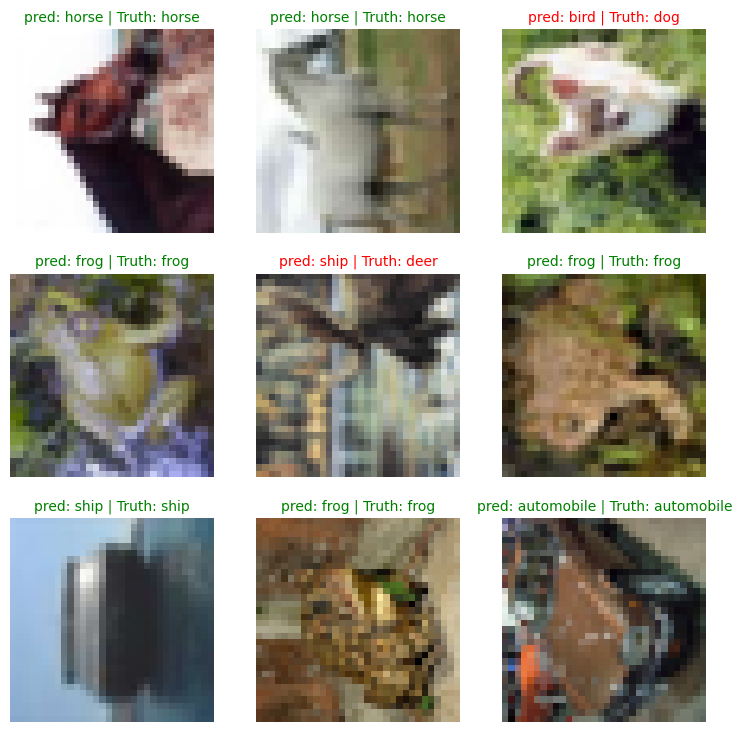

In [848]:
#plot predictions
plt.figure(figsize = (9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    #create subplot
    plt.subplot(nrows, ncols, i + 1)

    # plot the target image
    plt.imshow(sample.T.squeeze())

    # Find pred labels 
    pred_label = class_names[pred_classes[i]]

    # Get truth label
    truth_label = class_names[test_labels[i]]

    # Create title for the plot
    title_text = f"pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize = 10, c = "g")
    else:
        plt.title(title_text, fontsize = 10, c = "r")

    plt.axis(False)
               
plt.show

# Testing robust model on perturbed data

In [879]:
accuracies = []
examples = []
epsilons = [0, .001, 0.1]
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_dataloader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 6930 / 10000 = 0.693
Epsilon: 0.001	Test Accuracy = 5515 / 10000 = 0.5515
Epsilon: 0.1	Test Accuracy = 509 / 10000 = 0.0509


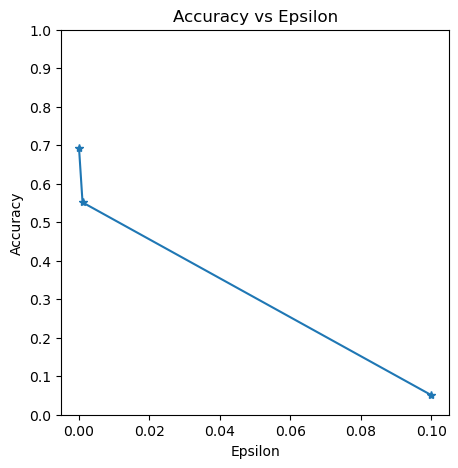

In [887]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.12, step=0.02))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

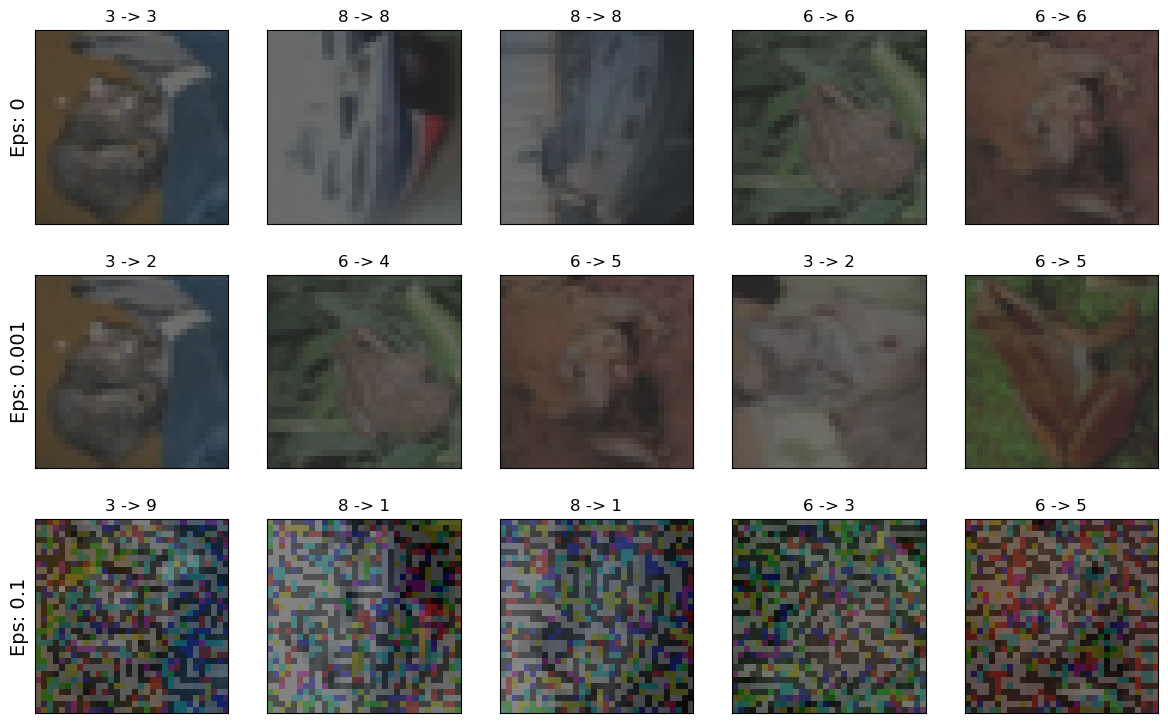

In [881]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(14.5,9))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex.T)
plt.show()